# Encoding Circuits

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from adjustText import adjust_text
from pathlib import Path
from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.providers import Backend
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from squlearn import Executor
from squlearn.encoding_circuit import (
    ChebyshevPQC,
    ChebyshevRx,
    HighDimEncodingCircuit,
    HubregtsenEncodingCircuit,
    MultiControlEncodingCircuit,
    ParamZFeatureMap,
    RandomLayeredEncodingCircuit,
    YZ_CX_EncodingCircuit,
)
from squlearn.encoding_circuit.encoding_circuit_base import EncodingCircuitBase
from squlearn.observables import SummedPaulis
from squlearn.optimizers import Adam
from squlearn.qnn import CrossEntropyLoss, QNNClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
X, y = load_digits(return_X_y=True)

In [4]:
def draw_encoding_circuits(encoding_circuits: list[EncodingCircuitBase]) -> None:
    for encoding_circuit in encoding_circuits:
        ax = encoding_circuit.draw("mpl")
        title = encoding_circuit.__class__.__name__
        if hasattr(encoding_circuit, "seed"):
            title += f"(seed={encoding_circuit.seed})"
        ax.suptitle(title)
        display(ax)

### Predefined Encoding Circuits

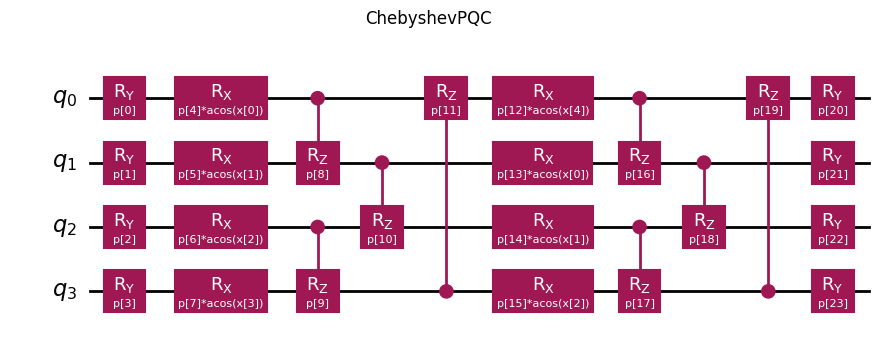

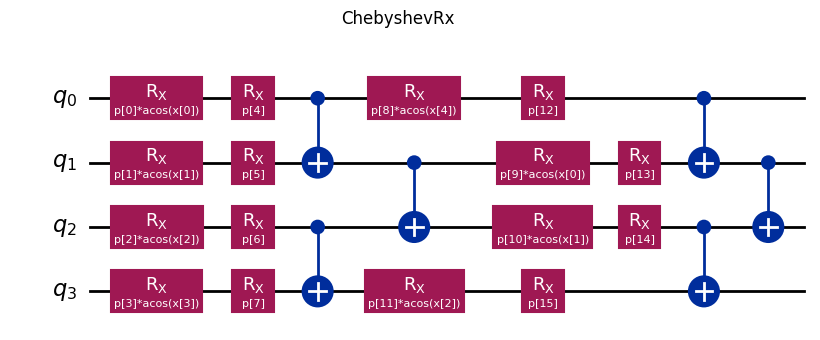

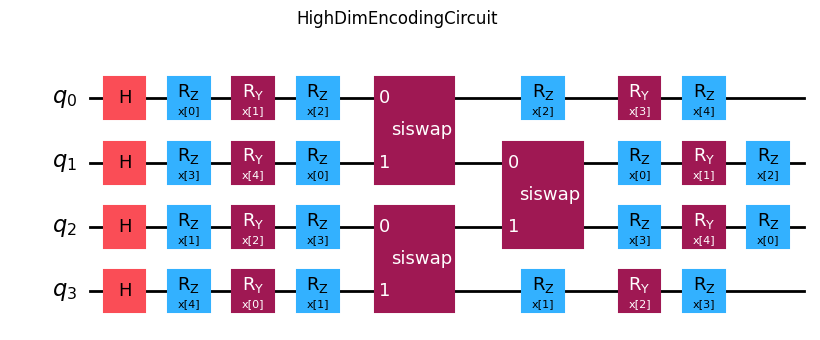

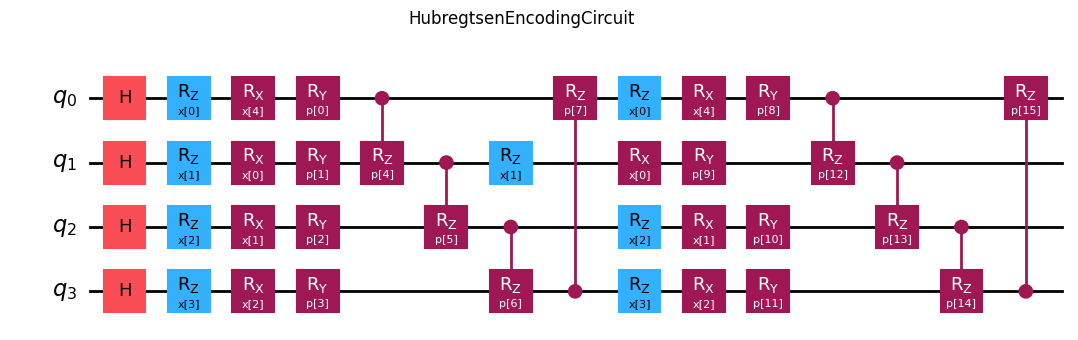

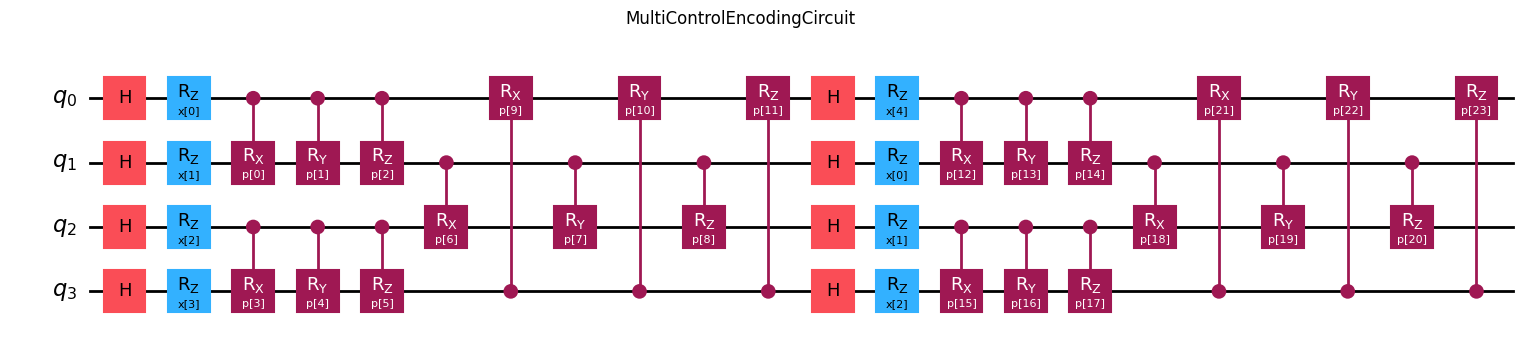

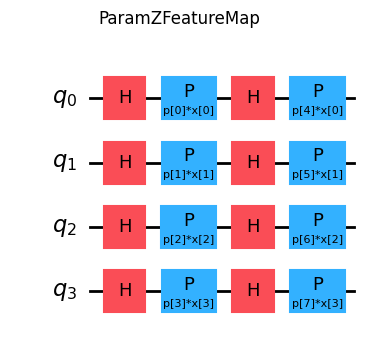

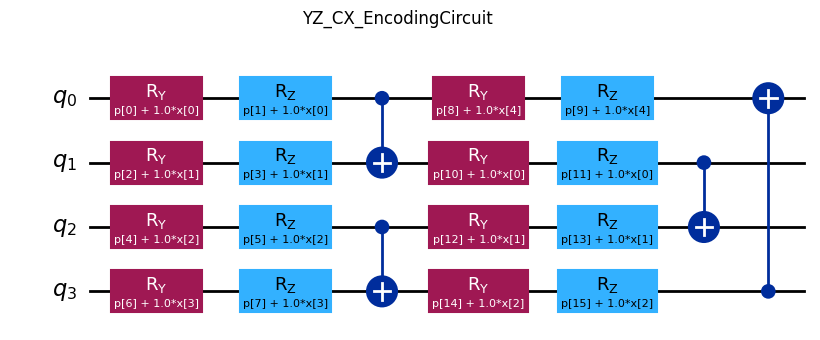

In [5]:
kwargs = {"num_qubits": 4, "num_layers": 2, "num_features": 5}
draw_encoding_circuits([
    ChebyshevPQC(**kwargs),
    ChebyshevRx(**kwargs),
    HighDimEncodingCircuit(**kwargs),
    HubregtsenEncodingCircuit(**kwargs),
    MultiControlEncodingCircuit(**kwargs),
    ParamZFeatureMap(**kwargs),
    YZ_CX_EncodingCircuit(**kwargs),
])

### Randomly Generated Encoding Circuits

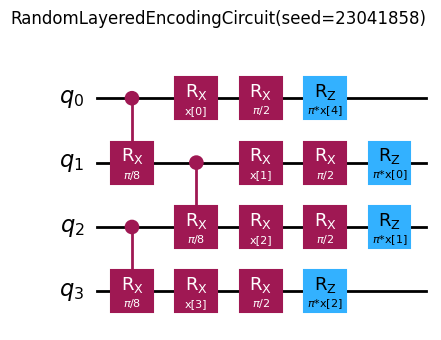

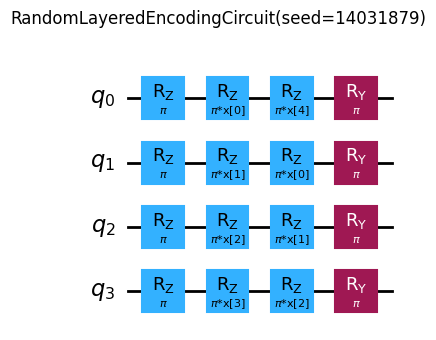

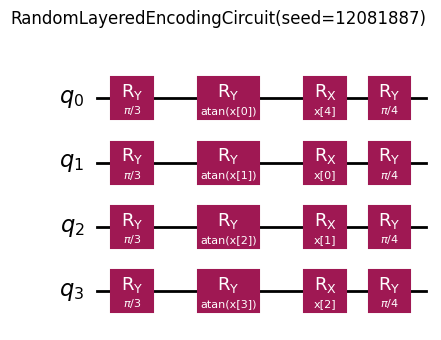

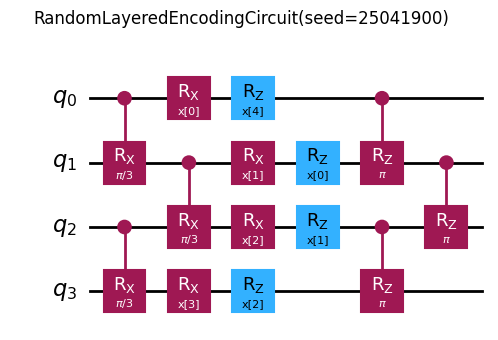

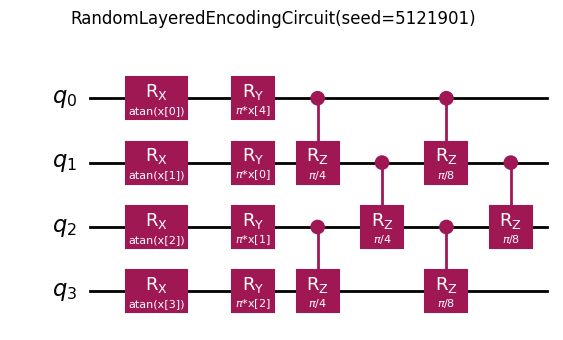

In [6]:
kwargs = {"num_qubits": 4, "num_features": 5, "min_num_layers": 4, "max_num_layers": 4}
draw_encoding_circuits([
    RandomLayeredEncodingCircuit(**kwargs, seed=23_04_1858),  # Planck
    RandomLayeredEncodingCircuit(**kwargs, seed=14_03_1879),  # Einstein
    RandomLayeredEncodingCircuit(**kwargs, seed=12_08_1887),  # Schrödinger
    RandomLayeredEncodingCircuit(**kwargs, seed=25_04_1900),  # Pauli
    RandomLayeredEncodingCircuit(**kwargs, seed=5_12_1901),  # Heisenberg
])

### Hyperparameter Search

In [7]:
for encoding_circuit in [
    ChebyshevPQC(num_qubits=1),
    ChebyshevRx(num_qubits=1),
    HighDimEncodingCircuit(num_qubits=1),
    HubregtsenEncodingCircuit(num_qubits=1),
    MultiControlEncodingCircuit(num_qubits=2),
    ParamZFeatureMap(num_qubits=1),
    YZ_CX_EncodingCircuit(num_qubits=1)
]:
    checkpoint_filename = f"checkpoints/encoding_circuits/{encoding_circuit.__class__.__name__.lower()}.csv"
    if os.path.isfile(checkpoint_filename):
        continue
    grid_search = GridSearchCV(
        estimator=Pipeline([
            ("feature_reduction", Isomap(n_components=5, max_iter=10_000)),
            ("feature_scaling", MinMaxScaler(tuple(encoding_circuit.feature_bounds), clip=True)),
            ("classifier", QNNClassifier(
                encoding_circuit=encoding_circuit,
                operator=len(np.unique(y)) * [SummedPaulis(num_qubits=1)],
                executor=Executor("qulacs"),
                loss=CrossEntropyLoss(),
                optimizer=Adam(),
            )),
        ]),
        param_grid={
            "classifier__num_qubits": [1, 2, 3, 4, 5],
            "classifier__num_layers": [1, 2, 3, 4, 5],
            "classifier__num_features": [5],
        },
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring="accuracy",
        n_jobs=-1,
    )
    grid_search.fit(X, y)
    checkpoint_df = pd.DataFrame(grid_search.cv_results_)[[
        "param_classifier__num_qubits",
        "param_classifier__num_layers",
        "param_classifier__num_features",
        "mean_test_score",
    ]].rename(columns={
        "param_classifier__num_qubits": "num_qubits",
        "param_classifier__num_layers": "num_layers",
        "param_classifier__num_features": "num_features",
        "mean_test_score": "accuracy",
    })
    checkpoint_df["encoding_circuit"] = encoding_circuit.__class__.__name__
    checkpoint_df.to_csv(checkpoint_filename, index=False)

In [8]:
for encoding_circuit in [
    RandomLayeredEncodingCircuit(num_qubits=1, seed=23_04_1858),  # Planck
    RandomLayeredEncodingCircuit(num_qubits=1, seed=14_03_1879),  # Einstein
    RandomLayeredEncodingCircuit(num_qubits=1, seed=12_08_1887),  # Schrödinger
    RandomLayeredEncodingCircuit(num_qubits=1, seed=25_04_1900),  # Pauli
    RandomLayeredEncodingCircuit(num_qubits=1, seed=5_12_1901),  # Heisenberg
]:
    checkpoint_filename = f"checkpoints/encoding_circuits/random_{encoding_circuit.seed}.csv"
    if os.path.isfile(checkpoint_filename):
        continue
    grid_search = GridSearchCV(
        estimator=Pipeline([
            ("feature_reduction", Isomap(n_components=5, max_iter=10_000)),
            ("feature_scaling", MinMaxScaler(tuple(encoding_circuit.feature_bounds), clip=True)),
            ("classifier", QNNClassifier(
                encoding_circuit=encoding_circuit,
                operator=len(np.unique(y)) * [SummedPaulis(num_qubits=1)],
                executor=Executor("qulacs"),
                loss=CrossEntropyLoss(),
                optimizer=Adam(),
            )),
        ]),
        param_grid=[{
            "classifier__num_qubits": [1, 2, 3, 4, 5],
            "classifier__min_num_layers": [num_layers],
            "classifier__max_num_layers": [num_layers],
            "classifier__num_features": [5],
        } for num_layers in [1, 2, 3, 4, 5]],
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring="accuracy",
        n_jobs=-1,
    )
    grid_search.fit(X, y)
    checkpoint_df = pd.DataFrame(grid_search.cv_results_)[[
        "param_classifier__num_qubits",
        "param_classifier__min_num_layers",
        "param_classifier__num_features",
        "mean_test_score",
    ]].rename(columns={
        "param_classifier__num_qubits": "num_qubits",
        "param_classifier__min_num_layers": "num_layers",
        "param_classifier__num_features": "num_features",
        "mean_test_score": "accuracy",
    })
    checkpoint_df["encoding_circuit"] = encoding_circuit.__class__.__name__
    checkpoint_df["seed"] = encoding_circuit.seed
    checkpoint_df.to_csv(checkpoint_filename, index=False)

### Evaluation

In [9]:
def deserialize_encoding_circuit(row: pd.Series) -> EncodingCircuitBase:
    encoding_circuit_cls = {
        cls.__name__: cls
        for cls in EncodingCircuitBase.__subclasses__()
    }[row["encoding_circuit"]]
    kwargs = {"num_qubits": row["num_qubits"], "num_features": row["num_features"]}
    if encoding_circuit_cls == RandomLayeredEncodingCircuit:
        kwargs.update({"seed": row["seed"], "min_num_layers": row["num_layers"], "max_num_layers": row["num_layers"]})
    else:
        kwargs.update({"num_layers": row["num_layers"]})
    return encoding_circuit_cls(**kwargs)


def get_num_gates(row: pd.Series, backend: Backend | None) -> int:
    encoding_circuit = deserialize_encoding_circuit(row)
    quantum_circuit = encoding_circuit.get_circuit(
        features=ParameterVector("x", encoding_circuit.num_features),
        parameters=ParameterVector("p", encoding_circuit.num_parameters),
    )
    transpiled_circuit = transpile(
        circuits=quantum_circuit,
        backend=backend,
    )
    return transpiled_circuit.size()


def get_label(row: pd.Series) -> str:
    short_name = row["encoding_circuit"].replace("EncodingCircuit", "")
    qubits, layers, seed = row["num_qubits"], row["num_layers"], row["seed"]
    if np.isnan(seed):
        return f"{short_name}(q={qubits},l={layers})"
    else:
        return f"{short_name}(q={qubits},l={layers},s={int(seed)})"


def plot_gates_vs_accuracy(results: pd.DataFrame, backend: Backend | None) -> None:
    results = results.copy()[results["accuracy"].notna()]

    results["num_gates"] = results.apply(
        func=lambda row: get_num_gates(row, backend),
        axis=1,
    )

    results = results.sort_values(
        by=["num_gates", "accuracy"],
        ascending=[True, False],
    )

    results["pareto_front"] = results["accuracy"] > results["accuracy"].cummax().shift(1, fill_value=-1)

    pareto_mask = results["pareto_front"]

    ax = results[pareto_mask].plot(
        kind="line",
        x="num_gates",
        xlim=(0, results["num_gates"].max() * 1.1),
        xlabel="Gates",
        y="accuracy",
        ylim=(0, 1),
        yticks=np.arange(0, 1.1, 0.1),
        ylabel="Accuracy",
        figsize=(16, 10),
        grid=True,
        linestyle="--",
        title=backend.__class__.__name__ if backend else "Simulator",
        legend=True,
        label="Pareto Front",
    )

    results[~pareto_mask].plot(
        kind="scatter",
        x="num_gates",
        xlabel="Gates",
        y="accuracy",
        ylabel="Accuracy",
        grid=True,
        alpha=0.25,
        s=30,
        ax=ax,
    )

    results[pareto_mask].plot(
        kind="scatter",
        x="num_gates",
        xlabel="Gates",
        y="accuracy",
        ylabel="Accuracy",
        grid=True,
        alpha=1.0,
        ax=ax,
    )

    texts = [
        ax.text(
            x=row["num_gates"],
            y=row["accuracy"],
            s=get_label(row),
            fontsize=10,
        )
        for idx, row in results[results["pareto_front"]].iterrows()
    ]

    adjust_text(texts, arrowprops={"arrowstyle": "->", "alpha": 0.25})

In [10]:
path = Path("checkpoints/encoding_circuits")
results = pd.concat([pd.read_csv(filename) for filename in path.glob("*.csv")], ignore_index=True)

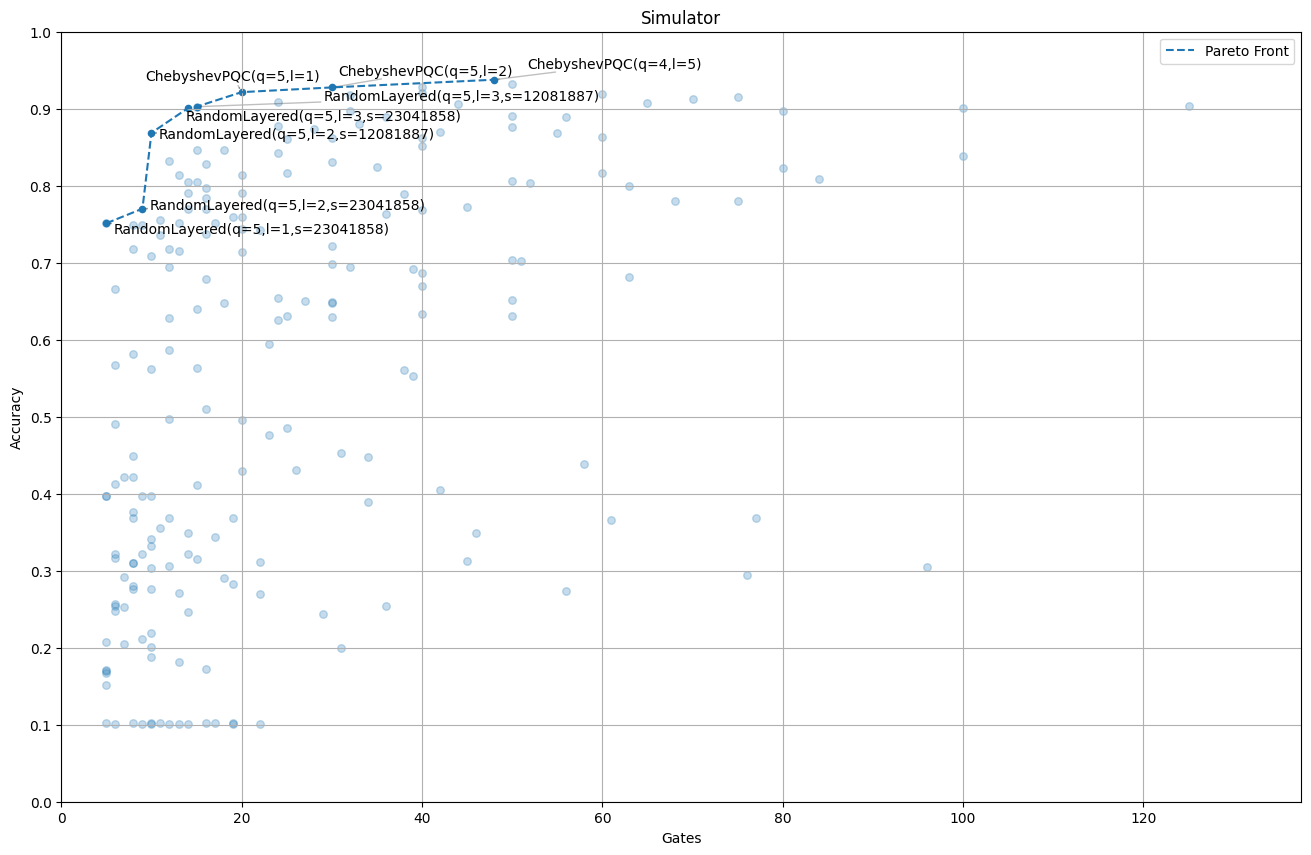

In [11]:
plot_gates_vs_accuracy(results=results, backend=None)

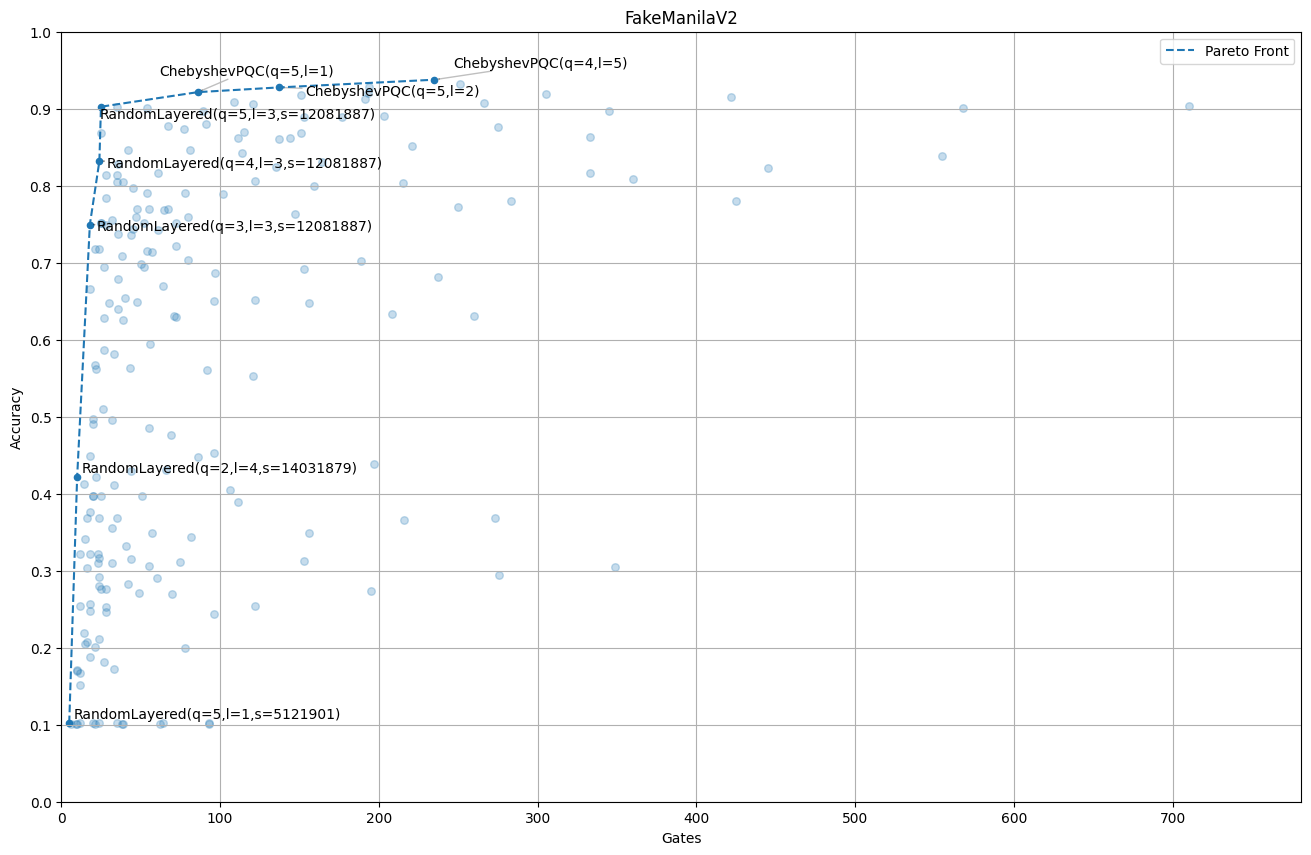

In [12]:
plot_gates_vs_accuracy(results=results, backend=FakeManilaV2())

### Decision

On the `FakeManilaV2` backend, the `RandomLayeredEncodingCircuit` with `num_qubits=5`, `num_layers=3`, and `seed=12_08_1887` (Schrödinger's birthday) at the elbow of the Pareto front represents the optimal trade-off between accuracy and gate count.

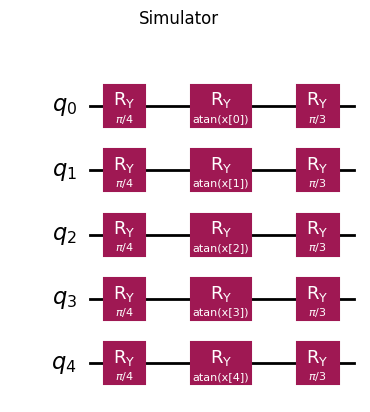

In [13]:
encoding_circuit = RandomLayeredEncodingCircuit(num_qubits=5, num_features=5, min_num_layers=3, max_num_layers=3, seed=12_08_1887)
fig = encoding_circuit.draw("mpl")
fig.suptitle("Simulator")
display(fig)

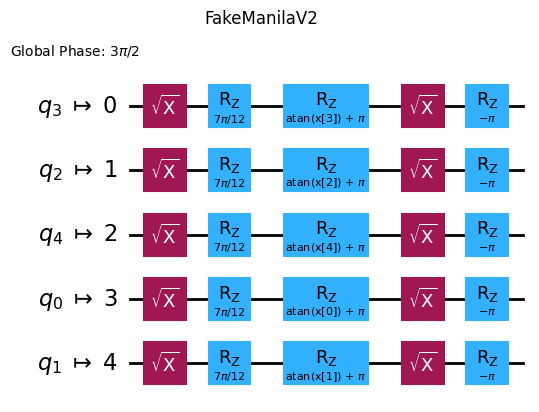

In [14]:
backend = FakeManilaV2()
transpiled_circuit = transpile(
    circuits=encoding_circuit.get_circuit(
        features=ParameterVector("x", encoding_circuit.num_features),
        parameters=ParameterVector("p", encoding_circuit.num_parameters),
    ),
    backend=backend,
)
fig = transpiled_circuit.draw("mpl")
fig.suptitle(backend.__class__.__name__)
display(fig)